---
format:
  html:
    embed-resources: true
    grid:
      sidebar-width: 0px
      body-width: 1100px
      margin-width: 200px
    theme:
      dark: darkly
      light: flatly
    fig-width: 9
    fig-height: 6
jupyter: python3
code-fold: true
code-overflow: wrap
---

# Full Analysis of Philippine Food prices from 2007 - 2025

## Aims:
1. Compare average prices across different regions for the same food item and year.
2. Examine how prices of a specific food item have changed over time.
3. Identify regional price variations for different food items.
4. Predict future food prices based on historical data.

In [96]:
from itables import init_notebook_mode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import plotly.express as px
import plotly.graph_objects as go
import scikit_posthocs as sp
import ipywidgets as widgets
from IPython.display import display, clear_output
from pmdarima import auto_arima
import warnings
import plotly.io as pio
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import json


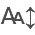

In [97]:
init_notebook_mode(all_interactive=True)
pio.renderers.default = "plotly_mimetype+notebook_connected"
warnings.filterwarnings("ignore")

In [98]:
file_path = "../Data/Processed/eda_results.csv"
df = pd.read_csv(file_path)

## Inspect the data

#### View the first few rows of the dataset

In [99]:
df.head()

Region Province Food_Items  year  mean  \
0  Autonomous region in Muslim Mindanao  Basilan      beans  2007   NaN   
1  Autonomous region in Muslim Mindanao  Basilan      beans  2008   NaN   
2  Autonomous region in Muslim Mindanao  Basilan      beans  2009   NaN   
3  Autonomous region in Muslim Mindanao  Basilan      beans  2010   NaN   
4  Autonomous region in Muslim Mindanao  Basilan      beans  2011   NaN   

   median  Mode  Variance  Standard Deviation  IQR  
0     NaN   NaN       NaN                 NaN  NaN  
1     NaN   NaN       NaN                 NaN  NaN  
2     NaN   NaN       NaN                 NaN  NaN  
3     NaN   NaN       NaN                 NaN  NaN  
4     NaN   NaN       NaN                 NaN  NaN

#### View the columns and data types of the dataset

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91200 entries, 0 to 91199
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Region              91200 non-null  object 
 1   Province            91200 non-null  object 
 2   Food_Items          91200 non-null  object 
 3   year                91200 non-null  int64  
 4   mean                78875 non-null  float64
 5   median              78875 non-null  float64
 6   Mode                36432 non-null  float64
 7   Variance            76125 non-null  float64
 8   Standard Deviation  76125 non-null  float64
 9   IQR                 78875 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 7.0+ MB


#### View the summary statistics of the dataset though this may not make sense as they are already described in the EDA report

In [101]:
df.describe()

year          mean        median          Mode      Variance  \
count  91200.000000  78875.000000  78875.000000  36432.000000  76125.000000   
mean    2016.000000    105.451058    104.863522     53.431795    122.240405   
std        5.477256     78.042087     77.886750     36.845196    563.636799   
min     2007.000000      3.913333      3.910000      4.000000      0.000000   
25%     2011.000000     45.180000     44.880000     21.550000      2.445597   
50%     2016.000000     83.240417     82.675000     50.880000     11.208699   
75%     2021.000000    157.035417    156.402500     82.030000     60.107766   
max     2025.000000    472.291667    470.625000    220.310000  24723.623884   

       Standard Deviation           IQR  
count        76125.000000  78875.000000  
mean             6.382062      7.540924  
std              9.028331     10.880566  
min              0.000000      0.000000  
25%              1.563840      1.665000  
50%              3.347940      3.950000  
75%              7.752920      9.345000  
max            157.237476    229.622500

#### check the shape of the dataset

In [102]:
df.shape

(91200, 10)

#### get the first and last year

In [103]:
df['year'].agg(['min', 'max'])

min    2007
max    2025
Name: year, dtype: int64

## Food Price Comparison by Region and Year

For comparing average prices across regions for the same food item and year, the closing price is generally the best price to use. Here’s why:

1. Consistency: The closing price is considered the most representative of the market's consensus for that period. It accounts for the entire trading session and reflects both supply and demand dynamics over time.
2. Standard Usage: The closing price is the most widely used price in financial markets, meaning data and analysis are typically focused around this price.
3. Simplicity: It eliminates the noise created by intra-day fluctuations, focusing on the price at the end of the trading session, which is more relevant for long-term comparisons.

In [104]:
# Filter the dataframe to keep only rows where 'food_item' starts with 'c_'
df_filtered = df[df['Food_Items'].str.startswith('c_')]

# remove the 'c_' from the 'food_item' column
df_filtered.loc[:, 'Food_Items'] = df_filtered['Food_Items'].str.replace('c_', '', regex=True)
df_filtered

Region         Province Food_Items  year  \
19     Autonomous region in Muslim Mindanao          Basilan      beans  2007   
20     Autonomous region in Muslim Mindanao          Basilan      beans  2008   
21     Autonomous region in Muslim Mindanao          Basilan      beans  2009   
22     Autonomous region in Muslim Mindanao          Basilan      beans  2010   
23     Autonomous region in Muslim Mindanao          Basilan      beans  2011   
...                                     ...              ...        ...   ...   
90302                           Region XIII  Surigao del Sur   tomatoes  2021   
90303                           Region XIII  Surigao del Sur   tomatoes  2022   
90304                           Region XIII  Surigao del Sur   tomatoes  2023   
90305                           Region XIII  Surigao del Sur   tomatoes  2024   
90306                           Region XIII  Surigao del Sur   tomatoes  2025   

            mean  median  Mode   Variance  Standard Deviation     IQR  
19     74.937500  74.850   NaN   0.414093            0.643501  1.1250  
20     73.472500  73.445   NaN   2.735784            1.654021  3.3500  
21     73.852500  73.690   NaN   1.378330            1.174023  2.1300  
22     74.190000  73.865   NaN   0.903018            0.950273  1.2125  
23     76.970000  76.740   NaN   0.445182            0.667219  0.6225  
...          ...     ...   ...        ...                 ...     ...  
90302  58.730000  60.485   NaN  53.710496            7.328744  6.6175  
90303  68.305833  69.285   NaN  37.754260            6.144450  6.4875  
90304  74.167500  77.150   NaN  73.676307            8.583490  9.0825  
90305  72.177083  71.815   NaN  45.560326            6.749839  8.5200  
90306  79.225000  79.225   NaN   1.531250            1.237437  0.8750  

[18240 rows x 10 columns]

In [105]:
#| label: fig-charts
#| fig-cap: "A line chart showing the mean and median price of each food item by region and year"

# Create figure
fig = go.Figure()

# Add traces for each food item and stat
food_items = df_filtered['Food_Items'].unique()
stats = ['mean', 'median']

for food in food_items:
    for stat in stats:
        df_food = df_filtered[df_filtered['Food_Items'] == food]
        for region in df_food['Region'].unique():
            df_region = df_food[df_food['Region'] == region]
            fig.add_trace(go.Scatter(
                x=df_region['year'],
                y=df_region[stat],
                mode='lines+markers',
                name=f"{food} - {region} ({stat})",
                visible=False
            ))

# Set initial visible traces (first food item, 'mean' stat)
initial_food = food_items[0]
initial_stat = 'mean'
for trace in fig.data:
    if initial_food in trace.name and initial_stat in trace.name:
        trace.visible = True

# Create separate dropdown buttons for food items and statistics
food_buttons = []
stat_buttons = []

for food in food_items:
    visibility = [food in trace.name and initial_stat in trace.name for trace in fig.data]
    food_buttons.append({
        'label': food,
        'method': 'update',
        'args': [{'visible': visibility},
                 {'title': f"{initial_stat.capitalize()} for {food} by Region and Year"}]
    })

for stat in stats:
    visibility = [initial_food in trace.name and stat in trace.name for trace in fig.data]
    stat_buttons.append({
        'label': stat,
        'method': 'update',
        'args': [{'visible': visibility},
                 {'yaxis': {'title': stat.capitalize()}},
                 {'title': f"{stat.capitalize()} for {initial_food} by Region and Year"}]
    })

# Update layout with separate dropdown menus
fig.update_layout(
    title=f"{initial_stat.capitalize()} for {initial_food} by Region and Year",
    xaxis_title="Year",
    yaxis_title=initial_stat.capitalize(),
    template="plotly_white",
    updatemenus=[
        {
            'buttons': food_buttons,
            'direction': 'down',
            'showactive': True,
            'x': 0,
            'xanchor': 'left',
            'y': 1.12,
            'yanchor': 'top',
        },
        {
            'buttons': stat_buttons,
            'direction': 'down',
            'showactive': True,
            'x': 0.28,
            'xanchor': 'left',
            'y': 1.12,
            'yanchor': 'top',
        }
    ]
)

# Show figure
fig.show()



### Key Observation
The graph shows the mean (average) price and/or median price of different food items over time for different regions in the Philippines.

1. Trend - Generally, the price of all food items has been increasing over the years across most regions. There are some fluctuations and periods of stability for some items, but the overall trend is upward.
2. Regional Differences - There is significant variation in price of different food items across regions. Some regions consistently have higher prices than others. Price fluctuations also varies between regions. Some regions experience more volatile prices than others.

### Key Reasons
Factors like weather patterns, government policies, agriculture changes, food transportation and global market trends can influence these prices.

## Price Difference over the Years

In [106]:
file_path = "../Data/Interim/cleaned_food_prices.csv"
df_range = pd.read_csv(file_path)

#dropping columns related to food price index
df_nofpi_range = df_range.drop(columns=['o_food_price_index', 'h_food_price_index', 'l_food_price_index', 'c_food_price_index', 'inflation_food_price_index', 'trust_food_price_index'])

# Convert 'Date' column to datetime format
df_nofpi_range['Date'] = pd.to_datetime(df_nofpi_range['Date'])

#dropping columns related to inflation
df_noinf_range = df_nofpi_range.drop(columns=['inflation_beans','inflation_cabbage', 'inflation_carrots', 'inflation_eggs', 'inflation_garlic', 'inflation_meat_beef_chops', 'inflation_meat_chicken_whole', 'inflation_meat_pork', 'inflation_onions', 'inflation_potatoes', 'inflation_rice', 'inflation_tomatoes'])

#dropping columns related to trust scores
df_cleaned_range = df_noinf_range.drop(columns=['trust_beans','trust_cabbage', 'trust_carrots', 'trust_eggs', 'trust_garlic', 'trust_meat_beef_chops', 'trust_meat_chicken_whole', 'trust_meat_pork', 'trust_onions', 'trust_potatoes', 'trust_rice', 'trust_tomatoes'])

#dropping uneeded columns
df_unneeded_range = df_cleaned_range.drop(columns=['country', 'City', 'lat', 'lon', 'Province', 'year', 'month'])

# Reshaping from wide to long format (including year and month as part of the identifier)
df_range = df_unneeded_range.melt(id_vars=['Region', 'Date'], var_name='Food_Items', value_name='Price')

df_range_filtered = df_range[df_range['Food_Items'].str.startswith('c_')]

df_range_filtered.loc[:, 'Food_Items'] = df_range_filtered['Food_Items'].str.replace('c_', '', regex=True)

price_stats = df_range_filtered.groupby(['Date', 'Food_Items'])['Price'].agg(['min', 'max', 'mean']).reset_index()
price_stats


Date Food_Items     min     max        mean
0    2007-01-01      beans   70.42   95.74   80.310734
1    2007-01-01    cabbage   25.20   58.40   37.012018
2    2007-01-01    carrots   34.98   78.04   46.501468
3    2007-01-01       eggs    3.98    5.06    4.257982
4    2007-01-01     garlic  114.26  228.09  147.541101
...         ...        ...     ...     ...         ...
2599 2025-01-01  meat_pork  280.44  377.49  341.611009
2600 2025-01-01     onions   96.21  189.44  137.476055
2601 2025-01-01   potatoes   90.83  166.20  126.217615
2602 2025-01-01       rice   45.15   56.24   49.658624
2603 2025-01-01   tomatoes   55.19  146.87   78.711927

[2604 rows x 5 columns]

In [107]:

def range_chart(price_stats):
    # Convert Date to datetime if it isn't already
    price_stats['Date'] = pd.to_datetime(price_stats['Date'])
    
    # Get unique food items for our dropdown
    food_items = sorted(price_stats['Food_Items'].unique())
    
    # Initialize our figure
    fig = go.Figure()
    
    # Create a list to store our dropdown menu options
    dropdown_buttons = []
    
    # For each food item, we'll create a filled range plot
    for i, food_item in enumerate(food_items):
        # Filter data for this specific food item
        item_data = price_stats[price_stats['Food_Items'] == food_item]
        
        # Create a filled range plot
        fig.add_trace(
            go.Scatter(
                x=item_data['Date'],
                y=item_data['max'],
                name='Price Range',
                mode='lines',
                line=dict(width=0),
                showlegend=False,
                visible=(i == 0)  # Only first item visible initially
            )
        )
        
        fig.add_trace(
            go.Scatter(
                x=item_data['Date'],
                y=item_data['min'],
                name=f'{food_item} Price Range',
                fill='tonexty',  # Fill area between traces
                mode='lines',
                line=dict(width=0),
                fillcolor='rgba(68, 138, 255, 0.4)',  # Semi-transparent blue
                visible=(i == 0)  # Only first item visible initially
            )
        )
        
        # Add a line for the mean price
        fig.add_trace(
            go.Scatter(
                x=item_data['Date'],
                y=item_data['mean'],
                name='Average Price',
                mode='lines',
                line=dict(
                    color='rgb(31, 119, 180)',
                    width=2
                ),
                visible=(i == 0)  # Only first item visible initially
            )
        )
        
        # Create visibility list for this food item's traces
        # Each food item has 3 traces (upper bound, lower bound, and mean)
        visible_list = [False] * (len(food_items) * 3)
        visible_list[i*3:(i*3)+3] = [True, True, True]
        
        # Add button for this food item to dropdown menu
        dropdown_buttons.append(
            dict(
                args=[{"visible": visible_list},
                      {"title": f"Price Range for {food_item} Over Time"}],
                label=food_item,
                method="update"
            )
        )
    
    # Update layout with dropdown menu and other customizations
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=dropdown_buttons,
                direction="down",
                showactive=True,
                x=0.05,
                y=1.15,
                xanchor="left",
                yanchor="top"
            )
        ],
        # Add title and axis labels
        title=f"Price Range for {food_items[0]} Over Time",
        xaxis_title="Date",
        yaxis_title="Price",
        hovermode='x unified',
        # Improve layout appearance
        template="plotly_white",
        margin=dict(t=110),  # Add top margin for dropdown
        # Improve legend layout
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    # Customize hover template to show min, max, and mean prices
    for trace in fig.data:
        trace.hovertemplate = '%{y:.2f}<extra></extra>'
    
    return fig

# Example usage:
fig = range_chart(price_stats)
fig.show()

In [108]:
price_stats['price_spread'] = price_stats['max'] - price_stats['min']

def spread_chart(price_stats):
    
    # Get unique food items for dropdown
    food_items = sorted(price_stats['Food_Items'].unique())
    
    # Initialize figure
    figrange = go.Figure()
    
    # Create a list to store dropdown menu options
    dropdown_buttons = []
    
    for i, food_item in enumerate(food_items):
        # Filter data for this food item
        item_data = price_stats[price_stats['Food_Items'] == food_item]
        
        # Create the main line plot for price spread
        figrange.add_trace(
            go.Scatter(
                x=item_data['Date'],
                y=item_data['price_spread'],
                name='Price Spread',
                mode='lines+markers',
                line=dict(color='blue', width=2),
                marker=dict(size=6),
                visible=(i == 0),
                customdata=np.stack((
                    item_data['min'],
                    item_data['max'],
                    item_data['mean']
                ), axis=-1),
                hovertemplate=(
                    '<b>Date</b>: %{x|%B %Y}<br>' +
                    '<b>Price Spread</b>: ₱%{y:.2f}<br>' +
                    '<b>Minimum Price</b>: ₱%{customdata[0]:.2f}<br>' +
                    '<b>Maximum Price</b>: ₱%{customdata[1]:.2f}<br>' +
                    '<b>Average Price</b>: ₱%{customdata[2]:.2f}<br>' +
                    '<extra></extra>'
                )
            )
        )
        
        # Calculate statistics for annotations
        avg_spread = item_data['price_spread'].mean()
        max_spread = item_data['price_spread'].max()
        max_spread_date = item_data.loc[item_data['price_spread'].idxmax(), 'Date']
        
        # Add a dashed line for average spread
        figrange.add_trace(
            go.Scatter(
                x=[item_data['Date'].min(), item_data['Date'].max()],
                y=[avg_spread, avg_spread],
                name='Average Spread',
                mode='lines',
                line=dict(color='red', width=2, dash='dash'),
                visible=(i == 0)
            )
        )
        
        # Create visibility list for this food item's traces
        visible_list = [False] * (len(food_items) * 2)
        visible_list[i*2:(i*2)+2] = [True, True]
        
        # Add button for this food item to dropdown menu
        dropdown_buttons.append(
            dict(
                args=[
                    {"visible": visible_list},
                    {
                        "title": f"Price Spread Analysis for {food_item}<br>"
                    }
                ],
                label=food_item,
                method="update"
            )
        )
    
    # Update layout
    figrange.update_layout(
        updatemenus=[
            dict(
                buttons=dropdown_buttons,
                direction="down",
                showactive=True,
                x=0.1,
                y=1.15,
                xanchor="left",
                yanchor="top"
            )
        ],
        title=f"Price Spread Analysis for {food_items[0]}",
        xaxis_title="Date",
        yaxis_title="Price Spread in ₱",
        template="plotly_white",
        margin=dict(t=120, b=50),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        # Add annotation
        annotations=[
            dict(
                text="Price Spread = Maximum Price - Minimum Price",
                xref="paper",
                yref="paper",
                x=0,
                y=-0.15,
                showarrow=False,
                font=dict(size=10)
            )
        ]
    )
    
    return figrange

figrange = spread_chart(price_stats)
figrange.show()

### Key Observations:
1. Overall Trend - Both the minimum and maximum prices show a general upward trend over the years, indicating an overall increase in the price of every food items. Some even recorded highest price increase on 2020, likely due to the COVID-19 pandemic and its impact on supply chains.
2. Price Range - The gap between the minimum and maximum prices for most items widens significantly in 2020 and 2021. This suggests that there were greater variations in prices across regions during these years.

### Posssible causes:
1. COVID-19 Pandemic - The pandemic disrupted supply chains and increased demand for certain food items, which could have led to price volatility.
2. Regional Differences - Differences in the impact of the pandemic on regional economies and agricultural production could have contributed to price variations.

## Regional Price difference

To truly know if the regions really have significant difference in prices over the years, hypothesis testing must be done. Please refer to <ins>..\Data\Processed\hypothesis_testing.ipynb</ins> to know why Kruskall-Wallis was used here.

#### View the first few rows of the dataset

In [109]:
#open the csv file that was already analyzed with kruskall wallis test.
hypothesis_results = "../Data/Processed/hypothesis_testing_result.csv"
hyp_df = pd.read_csv(hypothesis_results)
hyp_df.head()

Year  Food_Item  H-statistic        p-value           Result
0  2007      beans          NaN            NaN  Not Significant
1  2007    c_beans  1077.368029  2.491117e-218      Significant
2  2007  c_cabbage  1105.762042  2.066749e-224      Significant
3  2007  c_carrots  1093.290901  9.693593e-222      Significant
4  2007     c_eggs   905.101619  1.726764e-181      Significant

#### Filter the dataframe to keep only rows where 'food_items' starts with 'c_' and remove prefix '_c'

In [110]:
# Filter the dataframe to keep only rows where 'food_item' starts with 'c_'
hyp_df_filtered = hyp_df[hyp_df['Food_Item'].str.startswith('c_')]
# removing prefix _c in the food items
hyp_df_filtered.loc[:, 'Food_Item'] = hyp_df_filtered['Food_Item'].str.replace('c_', '', regex=True)
hyp_df_filtered.head()

Year Food_Item  H-statistic        p-value       Result
1  2007     beans  1077.368029  2.491117e-218  Significant
2  2007   cabbage  1105.762042  2.066749e-224  Significant
3  2007   carrots  1093.290901  9.693593e-222  Significant
4  2007      eggs   905.101619  1.726764e-181  Significant
5  2007    garlic   393.719714   3.807277e-73  Significant

#### check the the results via using table or check unique results

In [111]:
year_dropdown = widgets.Dropdown(
    options=hyp_df_filtered["Year"].unique(),
    value=hyp_df_filtered["Year"].min(),
    description="Select Year:",
    style={'description_width': 'initial'}
)

# Output widget to display the table
output = widgets.Output()

def update_table(change):
    with output:
        output.clear_output()
        display(hyp_df_filtered[hyp_df_filtered["Year"] == year_dropdown.value])

# Trigger update on change
year_dropdown.observe(update_table, names="value")

# Display widgets
display(year_dropdown, output)

# Initial Table Display
update_table(None)

Dropdown(description='Select Year:', options=(2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017…

Output()

In [112]:
# or you can just count the number of unique Results
hyp_df_filtered["Result"].value_counts()

Result
Significant    228
Name: count, dtype: int64

This means all the items for all the regions over the year have different prices. But which regions have different prices?

In [113]:
df_d = df_cleaned_range.drop(columns=['country', 'City', 'lat', 'lon', 'Province', 'Date', 'month'])

df_dt = df_d.melt(id_vars=['Region', 'year'], var_name='Food_Items', value_name='Price')
df_dt = df_dt[df_dt['Food_Items'].str.startswith('c_')]
df_dt.loc[:, 'Food_Items'] = df_dt['Food_Items'].str.replace('c_', '', regex=True)

#### Perform Dunn's Test and saved as csv file

In [114]:

# Perform Dunn's Test for all food items and years
dt_results = []
for item in df_dt['Food_Items'].unique():
    for year in df_dt['year'].unique():
        filter_dfdt = df_dt[(df_dt['Food_Items'] == item) & (df_dt['year'] == year)]
        if not filter_dfdt.empty:
            dunn_result = sp.posthoc_dunn(filter_dfdt, val_col='Price', group_col='Region')
            dunn_result['Food_Items'] = item
            dunn_result['year'] = year
            dt_results.append(dunn_result)

# Combine results into a single DataFrame and save to CSV
if dt_results:
    final_results = pd.concat(dt_results)
    final_results.to_csv("dunns_test_results.csv", index=True)
    print("Dunn's test results saved to dunns_test_results.csv")
else:
    print("No valid comparisons found.")

Dunn's test results saved to dunns_test_results.csv


In [115]:
# Read the CSV file
df = pd.read_csv('dunns_test_results.csv', index_col=0)

food_items = sorted(df['Food_Items'].dropna().unique())
years = sorted(df['year'].unique())

# Create initial heatmap data
def get_heatmap_data(food_item, year):
    """Filters the dataset and returns heatmap data."""
    filtered_data = df[(df['Food_Items'] == food_item) & (df['year'] == year)]
    
    if filtered_data.empty:
        return None, None, None  # No data available case

    heatmap_data = filtered_data.drop(columns=['Food_Items', 'year'])
    return heatmap_data.values, heatmap_data.columns, heatmap_data.index

# Initialize first heatmap
initial_food = food_items[0]
initial_year = years[0]
z_values, x_labels, y_labels = get_heatmap_data(initial_food, initial_year)

# Create figure
fig = go.Figure()

# Add initial heatmap
fig.add_trace(go.Heatmap(
    z=z_values,
    x=x_labels,
    y=y_labels,
    colorscale='rdylgn',
    colorbar=dict(title='p-value',
                  x=1.2,
                  titleside='top',
                  len=0.5
                 ),
    hoverongaps=False
))

# Update layout
fig.update_layout(
    title=dict(text=f"Dunn's Test Results: {food} ({initial_year})", 
                          font=dict(size=20),
                          y=0.98,
                          x=0.5,
                          ),
    height=620,
    width=800,
    margin=dict(l=10, r=10, t=25, b=1),
    xaxis=dict(tickangle=45, title='Region', constrain='domain'),
    yaxis=dict(title='Region', constrain='domain', scaleanchor='x', scaleratio=1)
)

# Add dropdowns for interactivity
dropdown_food = [
    {
        "label": food,
        "method": "update",
        "args": [
            {"z": [get_heatmap_data(food, initial_year)[0]]},  # Update heatmap
            {"title":dict(text=f"Dunn's Test Results: {food} ({initial_year})", 
                          font=dict(size=20),
                          y=0.98,
                          x=0.5,
                          )} 
        ]
    }
    for food in food_items
]

dropdown_year = [
    {
        "label": str(year),
        "method": "update",
        "args": [
            {"z": [get_heatmap_data(initial_food, year)[0]]},  # Update heatmap
            {"title":dict(text=f"Dunn's Test Results: {food} ({initial_year})", 
                          font=dict(size=20),
                          y=0.98,
                          x=0.5,
                          )} 
        ]
    }
    for year in years
]

fig.update_layout(
    updatemenus=[
        {
            "buttons": dropdown_food,
            "direction": "down",
            "showactive": True,
            "x": -1,
            "xanchor": "left",
            "y": 0.99,
            "yanchor": "top",
            "active": 0,
            "pad": {"r": 0.5, "t": 0.5},
            "name": "Food Item",
        },
        {
            "buttons": dropdown_year,
            "direction": "down",
            "showactive": True,
            "x": -0.47,
            "xanchor": "left",
            "y": 0.99,
            "yanchor": "top",
            "active": 0,
            "pad": {"r": 0.5, "t": 0.5},
            "name": "Year",
        }
    ]
)

fig.show()

This heatmap visualizes the results of a Dunn's post-hoc test for significant differences in prices of different food items between regions across the years.<br>
<space><br>
The color scale indicates the following:
*   Red (Close to 0): Indicates a statistically significant difference in food prices between two regions.
*   Light Green to Yellow (Around 0.2 to 0.8): Suggests a possible difference, but not statistically significant based on the chosen significance level (typically 0.05)
*   Dark Green (Close to 0): Indicates statistically no significant difference in bean prices between the two regions.

### Key Observations
1. Significant Differences Exist: The presence of so many red cells indicates that there are statistically significant differences in food prices in almost all regions at any given years.
2. No Significant Differences: patches of green indicate pairs of regions where the Dunn's test did not find a statistically significant difference in food prices, but there are only few of them.
3. Market Average Comparison: The "Market Average" row/column allows you to see how each region's prices compare to the overall average. Dark red cells in this row/column would indicate regions with prices significantly different from the market average.

## Food price Prediction 3 years into the future

In [1]:
forecasts_df = pd.read_csv('forecasts.csv')

def create_interactive_forecast_plot(forecasts_df):
    """Create an interactive forecast plot using Plotly."""
    
    # Get unique regions and items
    regions = sorted(forecasts_df['region'].unique())
    items = sorted(forecasts_df['item'].unique())

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces for all combinations
    for region in regions:
        for item in items:
            forecast = forecasts_df[
                (forecasts_df['region'] == region) & 
                (forecasts_df['item'] == item)
            ].iloc[0]
            
            # Parse JSON strings
            historical_dates = json.loads(forecast['historical_dates'])
            historical_values = json.loads(forecast['historical_values'])
            forecast_dates = json.loads(forecast['forecast_dates'])
            forecast_values = json.loads(forecast['forecast_values'])
            
            # Historical data trace
            fig.add_trace(
                go.Scatter(
                    x=historical_dates,
                    y=historical_values,
                    name="Historical",
                    line=dict(color='blue'),
                    visible=(region == regions[0] and item == items[0])
                ),
                secondary_y=False
            )

            # Forecast data trace
            fig.add_trace(
                go.Scatter(
                    x=forecast_dates,
                    y=forecast_values,
                    name="Forecast",
                    line=dict(color='red', dash='dash'),
                    visible=(region == regions[0] and item == items[0])
                ),
                secondary_y=False
            )

    # Create dropdown buttons
    def create_visibility_array(selected_region, selected_item):
        return [
            (r == selected_region and i == selected_item)
            for r in regions
            for i in items
            for _ in range(2)  # Two traces per combination
        ]

    def get_arima_text(region, item):
        forecast = forecasts_df[
            (forecasts_df['region'] == region) & 
            (forecasts_df['item'] == item)
        ].iloc[0]
        return (f"ARIMA({forecast['p']},{forecast['d']},{forecast['q']})"
                f"({forecast['P']},{forecast['D']},{forecast['Q']},12)")

    # Region Dropdown
    region_buttons = [
        dict(
            args=[
                {'visible': create_visibility_array(region, items[0])},
                {'annotations': [
                    dict(text="Region:", x=0, y=1.1, yref="paper", xref="paper", showarrow=False),
                    dict(text="Food Item:", x=0.3, y=1.1, yref="paper", xref="paper", showarrow=False),
                    dict(
                        text=f"Note: ARIMA parameters used: {get_arima_text(region, items[0])}",
                        x=0, y=-0.2, xref="paper", yref="paper",
                        showarrow=False, font=dict(size=12, color="gray")
                    )
                ]}
            ],
            label=region,
            method='update'
        ) for region in regions
    ]

    # Item Dropdown
    item_buttons = [
        dict(
            args=[
                {'visible': create_visibility_array(regions[0], item)},
                {'annotations': [
                    dict(text="Region:", x=0, y=1.1, yref="paper", xref="paper", showarrow=False),
                    dict(text="Food Item:", x=0.3, y=1.1, yref="paper", xref="paper", showarrow=False),
                    dict(
                        text=f"Note: ARIMA parameters used: {get_arima_text(regions[0], item)}",
                        x=0, y=-0.2, xref="paper", yref="paper",
                        showarrow=False, font=dict(size=12, color="gray")
                    )
                ]}
            ],
            label=item,
            method='update'
        ) for item in items
    ]

    updatemenus = [
        # Region Dropdown
        dict(
            buttons=region_buttons,
            direction='down',
            showactive=True,
            x=0.06,
            xanchor='left',
            y=1.115,
            yanchor='top'
        ),
        # Item Dropdown
        dict(
            buttons=item_buttons,
            direction='down',
            showactive=True,
            x=0.435,
            xanchor='left',
            y=1.115,
            yanchor='top'
        )
    ]

    # Initial ARIMA text
    initial_arima_text = get_arima_text(regions[0], items[0])

    # Update x-axis to show all years
    fig.update_xaxes(
        dtick="M12",  # Show tick mark for every 12 months
        tickformat="%Y",  # Show only the year
        tickangle=45,  # Angle the labels for better readability
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    )

    # Update layout with fixed dimensions and consistent annotations
    fig.update_layout(
        title='Price Forecast by Region and Food Item',
        xaxis_title='Date',
        yaxis_title='Price',
        updatemenus=updatemenus,
        annotations=[
            dict(text="Region:", x=0, y=1.1, yref="paper", xref="paper", showarrow=False),
            dict(text="Food Item:", x=0.4, y=1.1, yref="paper", xref="paper", showarrow=False),
            dict(text=f"Note: most optimized ARIMA parameters: {initial_arima_text}",
                 x=0, 
                 y=-0.2, 
                 xref="paper", 
                 yref="paper",
                showarrow=False, 
                font=dict(size=12, 
                          color="gray")
            )
        ],
        height=563,  # Fixed height
        width=1000,  # Fixed width
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.95
        ),
        margin=dict(t=95, b=95)  # Add margin to accommodate dropdown and annotation
    )

    return fig

# Create and display the interactive plot
fig = create_interactive_forecast_plot(forecasts_df)
fig.show()


NameError: name 'pd' is not defined

#### Key Observations
1. Historical Price Volatility: The blue line representing historical prices shows significant fluctuations, especially noticeable spikes around 2008 and smaller ones in other years. This indicates that most food prices have been subject to considerable volatility over the past two decades.
2. Recent Price Increase: There's a clear upward trend in food prices in the period leading up to the forecast (roughly from 2020 to 2024). This suggests recent factors have been pushing prices higher.
3. Relatively Stable Forecast: The red dashed line, representing the forecast for the next 36 months, shows a relatively stable and slightly upward trend. The model predicts a continued but moderated increase compared to the recent past.

#### Key Observations
1. Historical Volatility:
    * Weather Patterns:adverse weather events in key agricultural regions can significantly impact supply and cause price volatility.
    * Changes in Demand: Fluctuations in global demand, driven by population growth or economic factors, can also contribute to price swings.
2. Recent Price Increase:
    * Inflation: General inflation in the economy could be pushing up agricultural commodity prices.
    * Supply Chain Issues: Disruptions to global supply chains (e.g., due to pandemics, conflicts, or trade policies) can lead to shortages and price increases.
    * Increased Input Costs: Rising costs of fertilizers, fuel, and labor can increase the cost of food production, which could be passed on to consumers.
3. Relatively Stable Forecast:
    * Model Assumption: ARIMA models assume that, to some extent, future trends will resemble past patterns. The stable forecast suggests the model has not picked up any strong upward or downward pressures for the next 36 months beyond what is already captured in the recent trend.